### Machine Learning Predictions of the Titanic Data-Set

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', '{:.3f}'.format)

#### Useful Functions

In [2]:
#Activation Functions

def linear(H):
    return H
def Sigmoid(H):
    return 1/(1+np.exp(-H))
def ReLU(H):
    return H*(H>0)
def softmax(H):
    eH = np.exp(H)
    return eH/eH.sum(axis=1, keepdims=True)

#General Functions

def one_hot_encode(y):
    N = len(y)
    K = len(set(y))
    Y = np.zeros((N,K), dtype=int)
    for i in range(N):
        Y[i,y[i]] = 1
    return Y

def derivative(Z,a):
    if(a == linear):
        return 1
    elif( a ==Sigmoid):
        return Z*(1-Z)
    elif(a==np.tanh):
        return 1-Z**2
    elif(a==ReLU):
        return (Z>0).astype(int)
    else:
        ValueError("Uknown Activation, please ass the derivative here.")

#Loss Functions

def cross_entropy_regression(y, p_hat):
    return -(1/len(y))*np.sum(y*np.log(p_hat)+(1-y)*np.log(1-p_hat))

def cross_entropy_shallow(Y, P_hat):
    return -np.sum(Y*np.log(P_hat))

def cross_entropy(Y, P_hat):
    return -(1/len(Y))*np.sum(Y*np.log(P_hat))

def OLS(Y, Y_hat):
    return (1/(2*len(Y)))*np.sum((Y-Y_hat)**2)

#Metrics
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

def f1_recall_precision(y,y_hat):
    tp = 0
    fn = 0
    fp = 0

    y = y.astype(str)
    y_hat = y_hat.astype(str)

    counts = pd.DataFrame(data=(y+y_hat)).value_counts()

    tp = counts.loc['11'].iloc[0]
    fn = counts.loc['10'].iloc[0]
    fp = counts.loc['01'].iloc[0]

    if(tp+fn == 0):
        r = 0
    else:
        r = (tp)/(tp+fn)
    if(tp+fp == 0):
        p = 0
    else:
        p = (tp)/(tp+fp)
    if(r+p == 0):
        return (r,0,p)
    return (r, 2*((r*p)/(r+p)), p)

def R2(y, y_hat):
    return 1-np.sum((y-y_hat)**2)/np.sum((y-y.mean())**2)

##### Testset and Trainset Generation

In [3]:
def train_test_split(df):
    shuffled_df = df.sample(frac=1,random_state=0).copy()
    length = 1+df.shape[0]-int(df.shape[0]*.33)

    y_train = shuffled_df['Survived'].iloc[0:length].to_numpy()
    y_test = shuffled_df['Survived'].iloc[length:].to_numpy()
    x_train = shuffled_df.iloc[0:length,:].drop(['Survived'],axis=1, inplace=False).to_numpy()
    x_test = shuffled_df.iloc[length:,:].drop(['Survived'],axis=1, inplace=False).to_numpy()

    return (x_train, x_test, y_train, y_test)

#### Model Classes

##### Binary Logistic Regressor

In [4]:
class LogisticRegression():
    def __init__(self, thresh=.5):
        self.s = 1e-20
        self.W = None
        self.b = None
        self.thresh = thresh
    
    def fit(self, x, y, eta=1e-3, epochs=1e3, show_curve=True, seed = None ):
        epochs =int(epochs)
        N,D = x.shape

        #Initialization of Weights and Biases
        if(seed == None):
            self.seed = np.random.randint(10000)
            print(self.seed)
            np.random.seed(self.seed)
        else:
            self.seed = seed
            np.random.seed(seed)

        std_dev = np.sqrt(2/(N+D))

        self.W = np.random.randn(D) * std_dev
        self.b = np.random.randn(1) * std_dev

        #Build Container for Loss
        J = np.zeros(epochs)

        #SGD Progession
        for epoch in range(epochs):
            p_hat = self.__forward__(x) + self.s
            J[epoch] = cross_entropy_regression(y, p_hat)
            #Weights and Biases Update Rules
            self.W -= eta*(1/N)*x.T@(p_hat-y)
            self.b -= eta*(1/N)*np.sum(p_hat-y)
            pass
        
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel('epochs')
            plt.ylabel(r'$\mathcal{J}$')
            plt.title('Training Curve')
        pass
    def __forward__(self, x):
        return Sigmoid(x@self.W+self.b)
    def predict(self,x):
        return (self.__forward__(x) >= self.thresh).astype(np.int32)
    def predict_percent(self,x):
        return (self.__forward__(x)).astype(np.float32)

##### 2-Layer Perceptron

In [5]:
class Shallow_ANN():

    def fit(self, X, y, neurons=6, 
            eta = 1e-3, epochs = 1e3, show_curve=True, seed=None):
        epochs = int(epochs)
        N,D = X.shape
        Y = one_hot_encode(y)
        K = Y.shape[1]

        #Initialize Weights and Biases
        if(seed == None):
            self.seed = np.random.randint(10000)
        else:
            self.seed = seed
        np.random.seed(self.seed)

        std_dev = np.sqrt(2/(N+D))

        self.W = {l:np.random.randn(M[0],M[1])*std_dev for l,M in enumerate(zip([D,neurons],[neurons,K]),1)}
        self.B = {l:np.random.randn(M) *std_dev for l,M in enumerate([neurons,K],1)}

        #Define Activations
        self.a = {1: np.tanh,2:softmax}

        #Loss Container
        J=np.zeros(epochs)

        #Gradient Descent Progression
        for epoch in range(epochs):
            self.__forward__(X)
            J[epoch]= cross_entropy_shallow(Y, self.Z[2])
            #Weight Update Rules for Layer 2
            self.W[2] -= eta*(1/N)*self.Z[1].T@(self.Z[2]-Y)
            self.B[2] -= eta*(1/N)*(self.Z[2]-Y).sum(axis=0)

            #Weight Update Rules for Layer 1
            self.W[1] -= eta*(1/N)*X.T@((self.Z[2]-Y)@self.W[2].T
                                        *(1-self.Z[1]**2))
            self.B[1] -= eta*(1/N)*((self.Z[2]-Y)@self.W[2].T*
                                   (1-self.Z[1]**2)).sum(axis=0)
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel('epochs')
            plt.ylabel(r'$\mathcal{J}$')
            plt.title('Training Curve')
        pass
    def __forward__(self, X):
        self.Z = {0: X}
        for l in sorted(self.W.keys()):
            self.Z[l] = self.a[l](self.Z[l-1]@self.W[l]+self.B[l])
            pass
        pass

    def predict(self, X):
        self.__forward__(X)
        return self.Z[2].argmax(axis=1)

    pass

##### Artificial Neural Network with Back Propagation

In [6]:
class ANN():

    #Mode 1 = Regression, Mode = 0 Classification
    def __init__(self, architecture, activations=None, mode=0):
        self.mode=mode
        self.architecture = architecture
        self.activations = activations
        self.L = len(architecture) + 1 #Hidden layers + output


    def fit(self, X, y, eta = 1e-3, epochs = 1e3, show_curve=True, seed=None):
        epochs = int(epochs)
        N,D = X.shape

        if self.mode:   #Regression Mode
            Y = y
            K = 1
            loss_func = OLS
            out_act = linear
        else:           #Classification Mode
            Y = one_hot_encode(y)
            K = Y.shape[1]
            loss_func = cross_entropy
            out_act = softmax

        #Initialize Weights and Biases
        if(seed is None):
            self.seed = np.random.randint(10000)
        else:
            self.seed = seed
        np.random.seed(self.seed)

        std_dev = np.sqrt(2/(N))

        self.W = {l:np.random.randn(M[0],M[1]) * std_dev for l,M 
                  in enumerate(zip(([D]+self.architecture),
                                   (self.architecture+[K])),1)}
        self.B = {l:np.random.randn(M) * std_dev for l,M 
                  in enumerate(self.architecture+[K],1)}

        #Define Activations
        if(self.activations is None):
            self.a = {l : ReLU for l in range(1,self.L)}
        else:
            self.a = {l: act for l,act in enumerate(self.activations,1)}
       
        # Final Layer Activation
        self.a[self.L] = out_act 

        #Loss Container
        J=np.zeros(epochs)

        #Gradient Descent Progression
        for epoch in range(epochs):
            self.__forward__(X)
            J[epoch]= loss_func(Y, self.Z[self.L])
            dH = (1/N)*(self.Z[self.L]-Y)

            #Back-Propagtion
            for l in sorted(self.W.keys(), reverse=True):

                dW =self.Z[l-1].T@dH
                dB = dH.sum(axis=0)

                self.W[l] -= eta*dW
                self.B[l] -= eta*dB

                if(l > 1):
                    dZ = dH@self.W[l].T
                    dH = dZ*derivative(self.Z[l-1],self.a[l-1])
            pass
        pass

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel('epochs')
            plt.ylabel(r'$\mathcal{J}$')
            plt.title('Training Curve')
        pass

    def __forward__(self, X):
        self.Z = {0: X}
        for l in sorted(self.W.keys()):
            self.Z[l] = self.a[l](self.Z[l-1]@self.W[l]+self.B[l])
            pass
        pass

    def predict(self, X):
        self.__forward__(X)
        if(self.mode):
            return self.Z[self.L]
        return self.Z[self.L].argmax(axis=1)

    pass

#### Model Drivers

##### Model Run Functions

In [7]:
def evaluate_model(model, x, y, mode, p):
    y_hat = model.predict(x)

    recal, f1, pre =  f1_recall_precision(y,y_hat)
    acc = accuracy(y,y_hat)
    r2 = R2(y,y_hat)

    if(p):
        print(f"{mode} Accuracy: {acc : 0.4f}")
        print(f"{mode} Recall: {recal : 0.4f}")
        print(f"{mode} Precision: {pre : 0.4f}")
        print(f"{mode} f1: {f1 : 0.4f}")
        print(f"{mode} R2: {r2 : 0.4f}")

    return (recal, f1, pre, acc, r2)

In [8]:
def run_model(model, trainstests , 
              eta, epochs, architecture, 
              activations, curve=True, 
              seed=None, p=True):
    x_train, x_test, y_train, y_test = trainstests
    
    if(model == ANN):
        ann = model(architecture, activations=activations)
    else:
        ann = model()

    ann.fit(x_train, y_train, eta= eta, 
            epochs= epochs, show_curve= curve, 
            seed= seed)
    if(p):
        print(ann.seed)

    evaluate_model(ann, x_train, y_train, 'Training', p)
    if(p):
        print('-'*20)
    recal, f1, pre,acc, r2 = evaluate_model(ann, x_test, y_test, 'Testing', p)
    return (recal, f1, pre, acc, r2 ,ann.seed)


##### Test Model's Initial Weights Function

In [9]:
def repeat_tests(model, trainstests, eta=1e-2, epochs=2.5e4, 
         architecture=[6,5,4], activations=[np.tanh,ReLU,ReLU], runs=100, p=True):
    try:
        accs= pd.DataFrame(columns=['seed','acc', 'recall', 'F1', 'precision', 'R2'])
        for i in range(np.random.randint(9999),999999, 
                       np.random.randint(999)):
            recall, f1, pre, acc, r2, seed = run_model(model,
                                                trainstests,
                                                eta,
                                                epochs, 
                                                architecture,
                                                activations, 
                                                seed = i,
                                                curve=False,
                                                p=p)
            accs.loc[len(accs)] = [seed, acc, recall, f1, pre, r2]
            if(len(accs) > runs):       
                break
    except Exception as e:
        
        print(e)
        pass
    finally:
        accs['seed'] = accs['seed'].astype(int)
        if(p):
            print(accs.describe().drop('seed', axis=1))
            print(accs.sort_values(by='F1').tail().to_string(index=False))
        return accs.describe().drop('seed',axis=1)

        

##### LOFO Implementaion

In [10]:
def lofo(model, dataframe, columns=[], runs=10, line=False):
    dataframe = dataframe.drop(columns, axis=1)
    tt_data = train_test_split(dataframe)
    outputs = [list((repeat_tests(model, tt_data, eta= 14e-3,
                                epochs=5e3, runs=runs, p=False).loc['mean',:]*100).astype(int))]
    o_columns = ['Baseline']
    print('Baseline', end='->')
    for col in dataframe.columns:
        if(col == 'Survived'):
            pass
        else:
            data = dataframe.drop([col], axis=1)
            tt_data = train_test_split(data)
            outputs.append(list((repeat_tests(model, tt_data, eta= 14e-3,
                                epochs=5e3, runs=runs, p=False).loc['mean',:]*100).astype(int)))
            o_columns.append(col)
            print(col, end='->')
    if(line):
        pd.DataFrame(data=outputs, index=o_columns,
                     columns=['Accuracy','Recall','f1', 'Precision', 'R2']).plot(title='LOFO Results',
                                                                                grid=True, figsize=(5,4),  
                                                                                rot=90, ylabel='Metric %',
                                                                                xlabel='Dropped Feature')
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.show()
    return (np.array(outputs), o_columns)

#### Implementation

##### Import & Split Processed Data

In [11]:
df = pd.read_csv('titanicfinal.csv')
#df.drop(['Cabin'],inplace=True, axis=1)

In [12]:
trainstests = train_test_split(df)
(trainstests[0].shape,trainstests[1].shape,trainstests[2].shape,trainstests[3].shape)

((598, 8), (293, 8), (598,), (293,))

##### Test the Different Models

- eta=12e-3,epochs=1e4
- eta=15e-3
- eta= 14e-3,epochs=5e3 <-Final 

In [13]:
#repeat_tests(Shallow_ANN, trainstests, eta= 14e-3,epochs=1e4)

12783
Training Accuracy:  0.8478
Training Recall:  0.6959
Training Precision:  0.8580
Training f1:  0.7684
Training R2:  0.3418
--------------------
Testing Accuracy:  0.8191
Testing Recall:  0.6560
Testing Precision:  0.8913
Testing f1:  0.7558
Testing R2:  0.2605


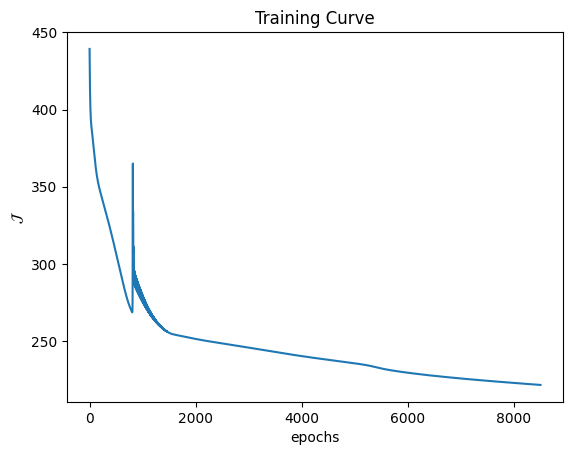

In [42]:
outputt = run_model(Shallow_ANN, trainstests, eta= 2e-2,epochs= 8.5e3, architecture=None, activations=None, seed= 12783)

In [15]:
# repeat_tests(ANN, trainstests, eta=6e-3,epochs= 1e4, 
#              architecture=[5,10], activations=[np.tanh,np.tanh])

8235
Training Accuracy:  0.8261
Training Recall:  0.6728
Training Precision:  0.8156
Training f1:  0.7374
Training R2:  0.2478
--------------------
Testing Accuracy:  0.8157
Testing Recall:  0.6480
Testing Precision:  0.8901
Testing f1:  0.7500
Testing R2:  0.2466


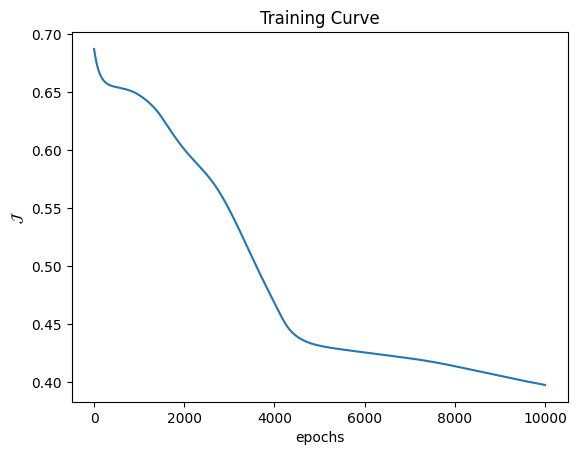

In [16]:
outputt = run_model(ANN, trainstests, eta=6e-3,epochs= 1e4, 
             architecture=[5,10], activations=[np.tanh,np.tanh,np.tanh], seed=8235)

In [17]:
accs = repeat_tests(Shallow_ANN, trainstests, eta= 14e-3,epochs=5e3, runs=10, p=False)
accs

,acc,recall,F1,precision,R2
count,11.000,11.000,11.000,11.000,11.000
mean,0.801,0.637,0.732,0.862,0.188
std,0.005,0.011,0.007,0.017,0.022
min,0.792,0.616,0.723,0.827,0.149
25%,0.799,0.632,0.728,0.852,0.177
50%,0.802,0.640,0.731,0.868,0.191
75%,0.804,0.644,0.736,0.874,0.198
max,0.812,0.656,0.749,0.878,0.233


Baseline->Age->Cabin->Class->FamilySize->Fare->NT->Sex->SmallFamily->

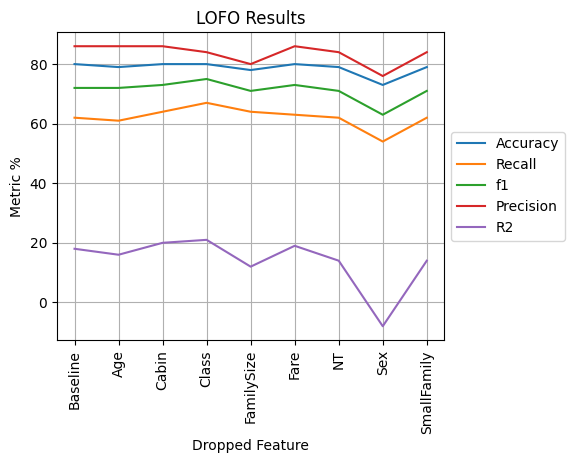

In [18]:
lf = lofo(Shallow_ANN, df, columns=[], runs=3, line=True)

Baseline->Age->Cabin->Class->FamilySize->Fare->NT->Sex->SmallFamily->

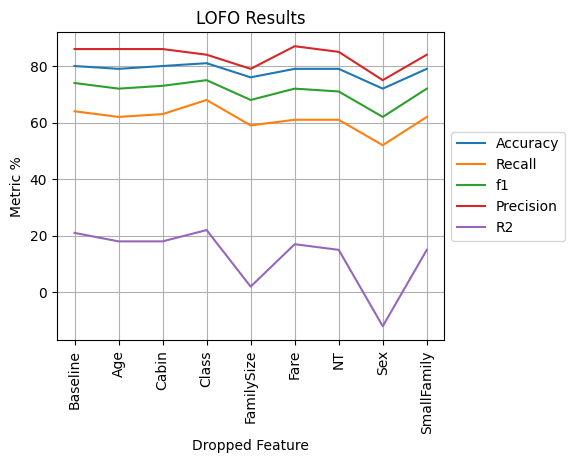

In [19]:
lf = lofo(Shallow_ANN, df, columns=[], runs=5, line=True)

Baseline->Age->Cabin->Class->FamilySize->Fare->NT->Sex->SmallFamily->

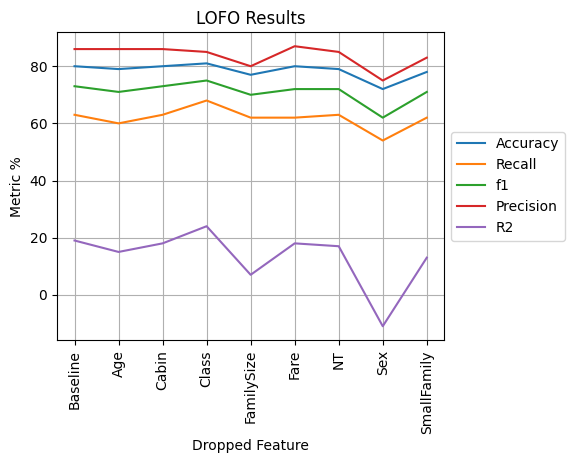

In [20]:
lf = lofo(Shallow_ANN, df, columns=[], runs=10, line=True)

Baseline->Age->Cabin->Class->FamilySize->Fare->NT->Sex->SmallFamily->

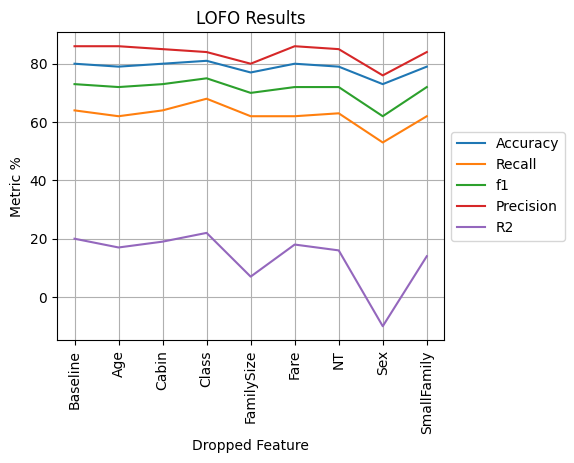

In [21]:
lf = lofo(Shallow_ANN, df, columns=[], runs=20, line=True)

In [40]:
repeat_tests(Shallow_ANN, trainstests, eta= 2e-2,epochs= 8.5e3,runs=30, architecture=None, activations=None)

1743
Training Accuracy:  0.8328
Training Recall:  0.6866
Training Precision:  0.8232
Training f1:  0.7487
Training R2:  0.2767
--------------------
Testing Accuracy:  0.8089
Testing Recall:  0.6400
Testing Precision:  0.8791
Testing f1:  0.7407
Testing R2:  0.2187
2295
Training Accuracy:  0.8278
Training Recall:  0.6037
Training Precision:  0.8851
Training f1:  0.7178
Training R2:  0.2550
--------------------
Testing Accuracy:  0.7645
Testing Recall:  0.5200
Testing Precision:  0.8784
Testing f1:  0.6533
Testing R2:  0.0373
2847
Training Accuracy:  0.8278
Training Recall:  0.6452
Training Precision:  0.8434
Training f1:  0.7311
Training R2:  0.2550
--------------------
Testing Accuracy:  0.7816
Testing Recall:  0.5760
Testing Precision:  0.8675
Testing f1:  0.6923
Testing R2:  0.1070
3399
Training Accuracy:  0.8378
Training Recall:  0.6820
Training Precision:  0.8409
Training f1:  0.7532
Training R2:  0.2984
--------------------
Testing Accuracy:  0.8020
Testing Recall:  0.6240
Testing

,acc,recall,F1,precision,R2
count,31.000,31.000,31.000,31.000,31.000
mean,0.799,0.614,0.722,0.879,0.180
std,0.016,0.043,0.031,0.011,0.067
min,0.765,0.520,0.653,0.859,0.037
25%,0.785,0.580,0.694,0.869,0.121
50%,0.802,0.624,0.731,0.879,0.191
75%,0.814,0.648,0.747,0.888,0.240
max,0.819,0.672,0.757,0.899,0.261
